In [14]:
from qiskit.circuit import QuantumCircuit
import matplotlib.pyplot as plt
import numpy as np
from qiskit.transpiler import PassManager

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit_ibm_runtime.transpiler.passes.scheduling import DynamicCircuitInstructionDurations, ALAPScheduleAnalysis, PadDelay

I'll use the AerSimulater. See [here](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/runtime_service#local-testing-mode)

In [3]:
from qiskit_aer import AerSimulator

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [5]:
from dotenv import load_dotenv
import os
load_dotenv()

True

At this point, we will not use the real machine, but I imported here

In [6]:
service = QiskitRuntimeService(channel='ibm_quantum', token=os.getenv(
    'IBMQ_TOKEN'), instance='ibm-q/open/main')

Use FakeKawasaki noise model

In [16]:
from qiskit_ibm_runtime.fake_provider import FakeKawasaki
device_backend = FakeKawasaki()

In [23]:
simulator = AerSimulator.from_backend(device_backend)
pass_manager = generate_preset_pass_manager(backend=simulator, optimization_level=0)
durations = DynamicCircuitInstructionDurations.from_backend(device_backend)
pass_manager.scheduling = PassManager(
    [ALAPScheduleAnalysis(durations), PadDelay(durations)])

Construct quantum circuits

In [28]:
qc = QuantumCircuit(1)
qc.x(0)
qc.delay(10, unit='us')
qc.measure_all()

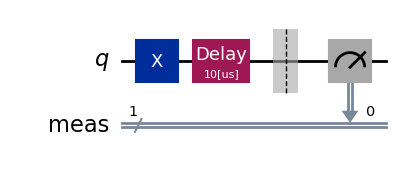

In [29]:
qc.draw("mpl")

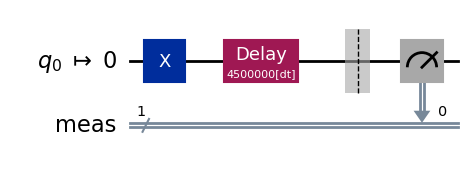

In [42]:
isa_qc = pass_manager.run(qc)
isa_qc.draw("mpl", idle_wires=False)

BitArray(<shape=(), num_shots=10000, num_bits=1>)


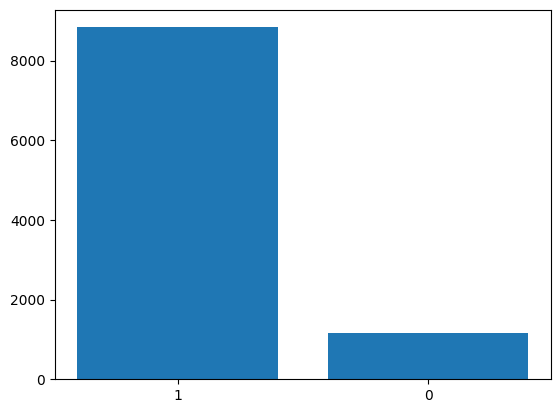

In [31]:
isa_qc = pass_manager.run(qc)
with Session(backend=simulator) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([isa_qc], shots=10000).result()[0].data.meas
    print(result)
    plt.bar(result.get_counts().keys(), result.get_counts().values())
    plt.show()

As an example, let's see how 1 de-excite with delay.

In [38]:
delays = np.logspace(0, 3, 15) # delays in us

In [39]:
rates = []
shots = 10000
for delay in delays:
    qc = QuantumCircuit(1)
    qc.x(0)
    qc.delay(delay, unit='us')
    qc.measure_all()
    isa_qc = pass_manager.run(qc)
    with Session(backend=simulator) as session:
        sampler = Sampler(mode=session)
        result = sampler.run([isa_qc], shots=shots).result()[0].data.meas
        rates.append(result.get_counts()['0']/shots)

/home/hfukuda/git/quantum_tomography/.venv/lib/python3.10/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 7371 [dt] = 1.638000e-06 [s] from 1.637894e-06 [s]
  warnings.warn(
/home/hfukuda/git/quantum_tomography/.venv/lib/python3.10/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 12072 [dt] = 2.682667e-06 [s] from 2.682696e-06 [s]
  warnings.warn(
/home/hfukuda/git/quantum_tomography/.venv/lib/python3.10/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 19773 [dt] = 4.394000e-06 [s] from 4.393971e-06 [s]
  warnings.warn(
/home/hfukuda/git/quantum_tomography/.venv/lib/python3.10/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 32386 [dt] = 7.196889e-06 [s] from 7.196857e-06 [s]
  warnings.warn(
/home/hfukuda/git/quantum_tomography/.venv/lib/python3.10/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 53045 [dt] = 1.178778e-05 [s] 

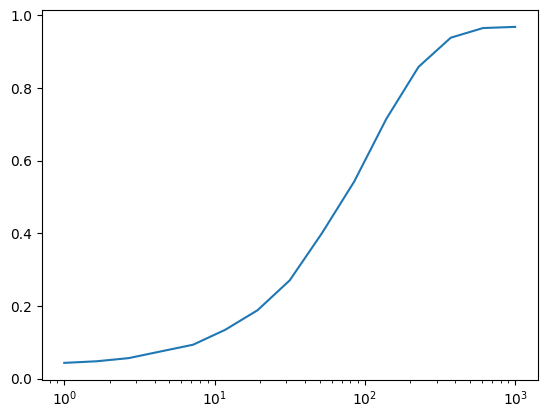

In [40]:
plt.plot(delays, rates)
plt.xscale('log')

Indeed, it de-excites into $|0\rangle$, although it is not completely exponential. 